In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

Предобрабатываем данные, я заранее записал результат некоторых затратных по времени операций в файлы, и закоментил создающие эти файлы, для удобства повторного запуска.

In [2]:
# cols = ['timestamp','user_id','hit','geo_id','category','price']
# data_raw = pd.read_csv('rfm.tsv',sep='\t', names=cols,
#                        dtype={'timestamp': np.int32})

In [3]:
# data_raw.price = data_raw.price.fillna(value=.0)
# data_raw.category=data_raw[['category','geo_id']].fillna(value='na').applymap(str)
# data_raw.timestamp = pd.to_datetime(data_raw['timestamp'],unit='s')
# data_raw.head()

При исследовании стало понятно, что где-то есть битые значения геолокаций, поэтому я сразу нахожу такое значение и заменяю его на наиболее общее 10000 - Земля

In [4]:
# data_raw.loc[~data_raw.geo_id.apply(lambda s: str(s).isdigit())]

In [5]:
# data_raw.set_value(6515728, 'geo_id', 10000)
# data_raw.loc[6515728]

In [6]:
# data_raw.geo_id = data_raw.geo_id.astype(int)

In [7]:
# data_raw.dtypes

Разбиваем логи на сессиии и создаем мультииндекс. (Здесь и далее я закоментил функции для затратных по времени операций, и записал результат в файлы)

In [8]:
# session_churn_threshold = dt.timedelta(hours=6)

# def split_sessions(udf):
#     udf = udf.sort_values(by='timestamp')
#     udf['session_num'] = ((udf.timestamp.diff() > session_churn_threshold).expanding().sum() + 1).astype(int)
#     return udf.set_index('session_num')

# data = data_raw.set_index('user_id').groupby(level=0, sort=False).apply(split_sessions)
# data.to_csv('data.csv')

In [9]:
data = pd.read_csv('data.csv', index_col=[0,1], parse_dates=['timestamp'])
data.head()

timestamp  \
user_id                          session_num                       
00002ad98ae4290672431d702c211b4a 1           2013-09-24 19:55:43   
00003cb9076039f584a12c2036fd3602 1           2013-07-22 07:57:47   
                                 1           2013-07-22 07:57:53   
                                 1           2013-07-22 07:58:10   
                                 1           2013-07-22 07:58:12   

                                                                                            hit  \
user_id                          session_num                                                      
00002ad98ae4290672431d702c211b4a 1                         /_c/YwrVrj_29IVZDmKxglT53wo7Pk8.html   
00003cb9076039f584a12c2036fd3602 1                                          /search?hid=7811975   
                                 1            /gate/cart-list.xml?sk=yd6558780959d5130b32e1a...   
                                 1            /model?modelid=1071569094&hid=7811975&show-uid...   
                                 1            /gate/model-glsearch.xml?hid=7811975&modelid=1...   

                                              geo_id category  price  
user_id                          session_num                          
00002ad98ae4290672431d702c211b4a 1             10000       na    0.0  
00003cb9076039f584a12c2036fd3602 1             10000  7811975    0.0  
                                 1             10000       na    0.0  
                                 1             10000  7811975    0.0  
                                 1             10000  7811975    0.0

In [10]:
start_date = data.timestamp.min()
end_date = data.timestamp.max()
print start_date, '\n', end_date

2012-12-31 20:00:53 
2013-12-31 19:58:37


Задача – увеличить LTV, за счет уменьшения оттока и увеличения частоты контакта.

Задачу можно разбить на 3 подзадачи:
1. Предотвращать отток для наиболее прибыльных пользователей.
2. Понять, что отличает наиболее прибыльных пользователей от не очень прибыльных. Выяснить, причина только в кол-ве сессий, или же есть другие причины (например в каком-то из регионов, представлено небольшое кол-во магазинов, при этом существует приличная пользовательская база)
3. Найти пользователей, которые совсем не приносят дохода, и выяснить причины. Возможно часть этих пользователей - скраперы

Также в этом задании я не буду учитывать пользователей совершивших только одну сессию. Кажется, что в таком случае нужно решать задачу оттока, но необходимо учитывать множество поведенческих триггеров (пользовался поиском, неудачный поиск, читал отзывы, глубина просмотра категорий), а также личную информацию пользователя. Такие тригеры лучше создавать зная как маркируются урлы. Категории товаров я тоже не буду учитывать, потому как по представленому файлу категорий нельзя восстановить дерево в нем отсутствуют многие уровни, в отличии от файла локаций.

In [11]:
users_monetary = data.price.groupby(level=0).sum()
users_monetary[users_monetary == 0.].shape[0] / float(users_monetary.shape[0]) * 100

81.53023983315954

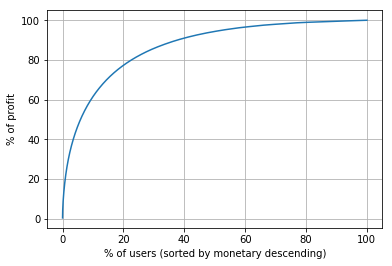

In [12]:
paying_users_monetary = users_monetary[users_monetary > 0]
plt.plot(\
    np.arange(0, 100, 100./paying_users_monetary.shape[0]),
    paying_users_monetary.sort_values(ascending=False).cumsum()/paying_users_monetary.sum()*100)
plt.grid(True)
plt.xlabel('% of users (sorted by monetary descending)')
plt.ylabel('% of profit')
plt.show()

Видим, что около 20% пользователей приносят около 80% дохода. Для них следует решать задачу удержания.
Посмотрим на распределение кол-ва сессий среди этих пользователей.

In [13]:
most_valued = pd.DataFrame()

In [14]:
most_valued['monetary'] = paying_users_monetary[paying_users_monetary > paying_users_monetary.quantile(q=.8)]
most_valued.head()

monetary
user_id                                   
00023fcc5c93cb4674bdad0d448272e6     425.0
00171bc1d3983650095137b2a7bdf70b     221.0
0019e537ea4d6442d59c110c03e135fb     302.0
001a792b4feb640d80dc916f7499ca5d     340.0
001c7f00e2948d3a89f856699d6db1ec     242.0

In [15]:
len(most_valued)

11028

In [16]:
# most_valued_data = data.loc[most_valued.index.values.tolist()]
# most_valued_data.to_csv('most_valued_data.csv')

most_valued_data = pd.read_csv('most_valued_data.csv', index_col=[0,1],  parse_dates=['timestamp'])

In [17]:
most_valued['frequency'] = most_valued_data.groupby(level=0,sort=False).apply(lambda udf: udf.index.values[-1][1])

In [18]:
def plot_frequency(frequency_series):
    
    fig, ax1 = plt.subplots(figsize=(16, 6))

    step = 4
    bins = frequency_series.values.max() / step + 1

    ax1.hist(frequency_series, bins=bins, alpha=.5)

    ax2 = ax1.twinx()
    ax2.hist(frequency_series, bins=bins, cumulative=True, histtype='step', normed=True)

    ax2.set_xticks(np.arange(0,frequency_series.values.max(), step))
    ax2.set_yticks(np.arange(0,1.1, .1))

    plt.setp(ax1.get_xticklabels()[1::2], visible=False)
    ax2.yaxis.grid(True)
    ax1.xaxis.grid(True)


    plt.show()

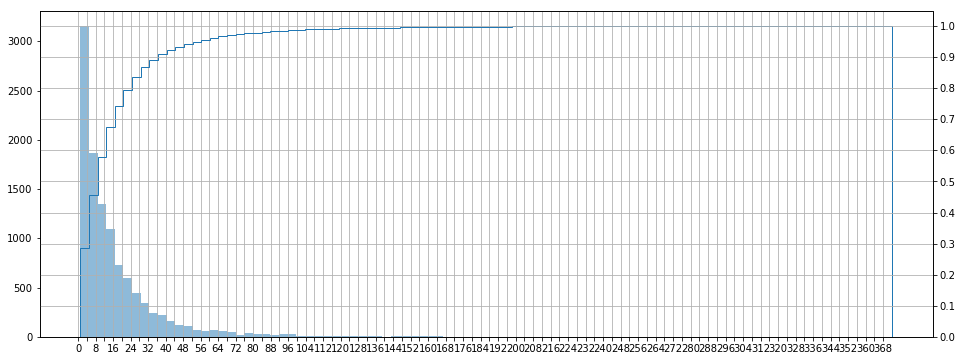

In [19]:
plot_frequency(most_valued['frequency'])

Число значимых пользователей совершивших только одну транзакцию:

In [20]:
print len(most_valued[most_valued.frequency == 1])
print len(most_valued[most_valued.frequency == 1]) / float(len(most_valued))

1180
0.107000362713


In [21]:
print len(most_valued[most_valued.frequency > 100])
print len(most_valued[most_valued.frequency > 100]) / float(len(most_valued))

129
0.0116974972797


11% самых пользователй совершили только 1 сессию. Мы не будем сейчас рассматривать этих пользователей. Во-первых о них мало что известно, во-вторых проблему эффективной первой сессии лучше решить отдельно. Сконцентрируемся пока на оттоке пользователей, которые совершили хотя бы 2 сессии. Также из графика выше видно, что 1% пользователей с очень большим количеством сессий (> 100 в год), природа такой активности мне не понятна, этот вопрос стоит изучить отдельно, возможно дело в скликивании.

In [22]:
most_valued = most_valued[(most_valued.frequency > 1) & (most_valued.frequency < 100)]
# most_valued_data = most_valued_data.loc[most_valued.index.values.tolist()]
# most_valued_data.to_csv('most_valued_upd_data.csv')

most_valued_data = pd.read_csv('most_valued_upd_data.csv', index_col=[0,1], parse_dates=['timestamp'])

len(most_valued)

9716

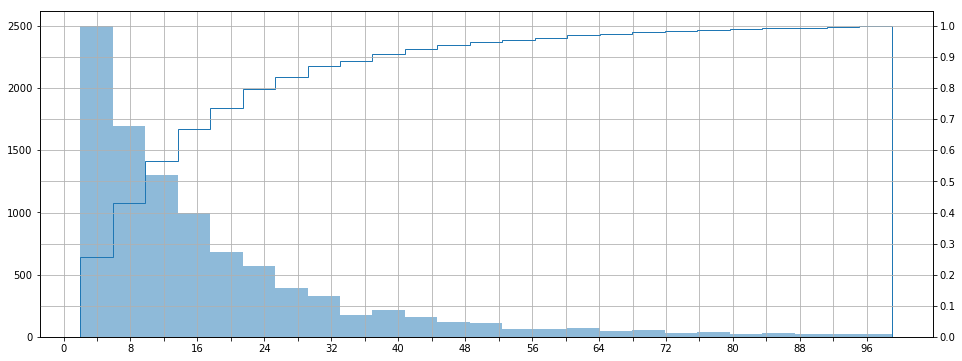

In [23]:
plot_frequency(most_valued['frequency'])

Далее мы будем строить модель оттока.
Сразу отмечу, что цель построения модели – определение важных признаков для их последующего анализа и только она, поэтому я не делю исходные данные по времени и буду "заглядывать в будущее". Такая модель, конечно же не подходит для использования в реалтайме, но позволит оценить важность некоторых признаков и запланировать эксперементы.

Для начала сформулируем определение оттока. Будем считать пользователя сгоревшим если он отсутствует на сервисе какое-то время.
Выбор порога оттока должен удовлетворять 2м критериям.
1) Под него должно попадать разумное кол-во пользователей
2) Доля вернувшихся пользователей при выборе такого порога должна быть минимальна.

Построим распределение максимальных лагов между сессиями в днях.

In [24]:
most_valued_data.dtypes

timestamp    datetime64[ns]
hit                  object
geo_id                int64
category             object
price               float64
dtype: object

In [25]:
most_valued_lags = most_valued_data.groupby(level=0).apply(lambda udf: udf.timestamp.diff().max().days)

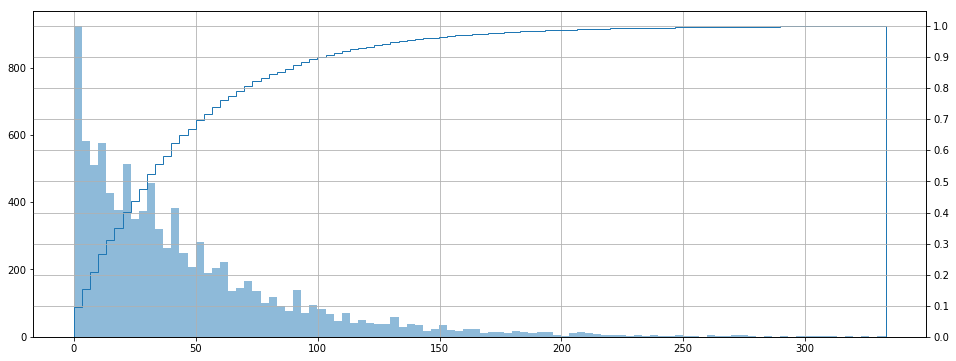

In [26]:
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.hist(most_valued_lags, 100, alpha=.5)
ax2 = ax1.twinx()
ax2.hist(most_valued_lags, 100, cumulative=True, normed=1, histtype='step')
ax2.set_yticks(np.arange(0,1.1, .1))
ax2.yaxis.grid(True)
ax1.xaxis.grid(True)
plt.show()

In [27]:
most_valued['recency'] = most_valued_data.groupby(level=0,sort=False)\
    .apply(lambda udf: (end_date - udf.timestamp.max()).days)

In [28]:
churn_threshold = 135
print sum(most_valued.recency > churn_threshold) /  float(len(most_valued_lags))
print sum(most_valued_lags.values > churn_threshold) / float(len(most_valued_lags))

0.33841086867
0.0500205846027


Попробовав разные пороги, я выбрал порог в 135 дней. Т.к. отток в 34% кажется возможным, при этом ошибка такого определения 5%.

In [29]:
most_valued['churned'] = most_valued.recency > churn_threshold

Посмотрим на корреляцию между колличеством сессий и сгоранием клиента

In [30]:
most_valued[['churned', 'frequency']].corr(method='spearman')

churned  frequency
churned    1.000000  -0.208719
frequency -0.208719   1.000000

Видим обратную корреляцию, но значение не так велико чтобы делать какие-то выводы, поэтому передем к созданию признаков для классификации.
Возможно сгорание связано с совокупностью факторов, включая локацию, среднюю продолжительность сессии и др.

In [31]:
geo_table = pd.read_table('geo_table', header=0)
geo_table.head()

id                           name  parent_region_id  type  TZ_OFFSET
0   1    Москва и Московская область               3.0     5      10800
1   2                Санкт-Петербург           10174.0     6      10800
2   3  Центральный федеральный округ             225.0     4      10800
3   4                       Белгород          120914.0     6      10800
4   5                        Иваново          120943.0     6      10800

In [32]:
geo_table.dtypes

id                    int64
name                 object
parent_region_id    float64
type                  int64
TZ_OFFSET             int64
dtype: object

In [33]:
pd.isnull(geo_table.parent_region_id).sum()

1

In [34]:
nan_index = geo_table.parent_region_id[pd.isnull(geo_table.parent_region_id)].index.values[0]
geo_table.loc[nan_index]

id                  10000
name                Земля
parent_region_id      NaN
type                    0
TZ_OFFSET               0
Name: 27152, dtype: object

In [35]:
geo_table.parent_region_id = geo_table.parent_region_id.fillna(0).astype(int)
geo_table.dtypes

id                   int64
name                object
parent_region_id     int64
type                 int64
TZ_OFFSET            int64
dtype: object

Посмотрим как часто встречаются ситуации когда в одной сессии встречаются несколько геопозиций

In [36]:
from collections import Counter
Counter([len(geos) for geos in most_valued_data.groupby(level=[0,1], sort=False)\
         .apply(lambda sdf: sdf.geo_id.unique()).values])

Counter({1: 121494, 2: 42187, 3: 1234, 4: 29, 5: 6, 6: 2, 7: 2, 8: 1, 15: 1})

Видим, что иногда в сессии встречаются геопозиции на разных уровнях дерева иерархии, такое происходит, по всей видимости, если геопозицию не удалось определить точно. Из предположения, что геопозиция остается постоянной внутри одной сессии, будем считать что геопозиция сессии – это геопозиция с наибольшей глубиной в дереве иерархии. Построим дерево

In [37]:
from treelib import Tree

class Geo:
    def __init__(self, geo_table):
        self.table = geo_table.set_index('id')
        self.tree = self.__build_tree()
        self.depths = self.__extract_depths()
    
    def __build_tree(self):
        tree = Tree()
        root_id = 0
        tree.create_node("root", root_id)
        
        for i,geo in self.table.iterrows():
            self.__add_geo_to_tree(geo, tree)
        
        return tree
    
    def __add_geo_to_tree(self, geo, tree):
        if tree.get_node(geo.name):
            pass
        else:
            items = []
            while not tree.get_node(geo.parent_region_id):
                items.append(geo)
                geo = self.table.loc[geo.parent_region_id]                

            tree.create_node(geo['name'], geo.name, parent=geo.parent_region_id)

            p = geo
            while len(items):
                cur = items.pop()
                tree.create_node(cur['name'], cur.name, parent=p.name)
                p = cur
    
    def __extract_depths(self):
        depths = pd.DataFrame(((node.identifier, self.tree.depth(node.identifier)) for node in self.tree.all_nodes()))\
            .set_index(0)[1]
        
        return depths

In [38]:
%%time
geo = Geo(geo_table)
print geo.tree.size()

51667
CPU times: user 6.56 s, sys: 99 ms, total: 6.66 s
Wall time: 6.65 s


In [74]:
from itertools import chain

class GeoFeaturesExtractor:
    def __init__(self, geo, data, min_interested_level=4, default_geo=10000):
        self.data = data
        self.geo = geo
        self.min_interested_level = min_interested_level
        self.default_geo=default_geo
        
        self.features = None
        
    def run(self):
        
        self.features = self.data.geo_id\
            .groupby(level=[0,1], sort=False).apply(self.__by_session)\
            .groupby(level=0).apply(self.__by_user)
                
        return self
    
    # извлекаем позицию наибольшей глубины, неизвестные дереву геопозиции заменяем на 10000 (Земля)
    def __by_session(self, sgeos):
        
        sgeos_unique = sgeos.unique()
        sgeos_known = np.where(\
                np.in1d(sgeos_unique, self.geo.depths.index.values),\
                sgeos_unique,\
                len(sgeos_unique) * [self.default_geo])
        geo = sgeos_known[np.argmax(self.geo.depths.loc[sgeos_known].values)]
    
        return geo
        
    # для каждой уникальной геопозиции поднимаемся вверх по дереву до уровня 4 включительно. Таким образом если проблема
    # окажется на уровне города, района, региона, то классификатор заметит ее.
    def __by_user(self, ugeos):
        
        geos = np.unique(list(chain(*map(\
                lambda g: list(self.geo.tree.rsearch(g))[:-self.min_interested_level+1],ugeos.unique()))))
                
        return geos
    
    

In [55]:
len(most_valued_data)

3956812

In [234]:
# %%time
# gfe = GeoFeaturesExtractor(geo, most_valued_data).run()

In [56]:
# gfe.features.head()

In [141]:
class NumericalFeaturesExtractor:
    
    def __init__(self, data):
        self.data = data
        
    def run(self):
        
        self.features = self.data\
            .groupby(level=[0,1], sort=False).apply(self.__by_session)\
            .groupby(level=0).apply(self.__by_user)
                
        return self
    
    def __by_session(self, sdf):
        return pd.Series({
            'landing_page': sdf.ix[0,'hit'],
            'num_pages': sdf.shape[0],
            'duration': (sdf.timestamp.max() - sdf.timestamp.min()).seconds//60.,
            'payments_num': len(sdf[sdf.hit == 'click']),
            'date': sdf.timestamp[0]
        })

    def __by_user(self, udf):
        return pd.Series({
            'session_count': udf.index.get_level_values(1).max(),
            'active_days': (udf.date.max() - udf.date.min()).days,
            'paying_session_count': len(udf[udf.payments_num > 0]),
            'mean_session_page_count': udf.num_pages.mean(),
            'med_session_page_count': udf.num_pages.median(),
            'max_session_page_count': udf.num_pages.max(),
            'mean_lag': udf.date.diff().mean().days,
            'med_lag': udf.date.diff().median().days,
            'max_lag': udf.date.diff().max().days,
            'mean_duration': udf.duration.mean(),
            'med_duration': udf.duration.median(),
            'count_self_entrance': len(udf[udf.landing_page == '/']),
            'last_session_duration': udf.iloc[-1,:].duration,
            'prelast_session_duration': udf.iloc[-2,:].duration,
            'last_session_payments': udf.iloc[-1,:].payments_num,
            'prelast_session_payments': udf.iloc[-2,:].payments_num
        })

In [60]:
# %%time
# nfe = NumericalFeaturesExtractor(most_valued_data).run()

In [62]:
# nfe.features.shape

In [61]:
# nfe.features.head()

In [551]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
mlb = MultiLabelBinarizer()


# geo_features = pd.DataFrame(data=mlb.fit_transform(gfe.features), columns=mlb.classes_, index=gfe.features.index)
# numerical_cols = nfe.features.columns.values
# target = most_valued['churned']

# sample_raw = pd.concat([target, nfe.features, geo_features], axis=1)
# sample_raw.to_csv('most_valued_sample_raw.csv')


scaler = StandardScaler()
sample_raw = pd.read_csv('most_valued_sample_raw.csv', index_col=[0])
numerical_cols_indexes = range(1,17)

sample = sample_raw.copy()
sample.iloc[:,numerical_cols_indexes] = scaler.fit_transform(sample.iloc[:,numerical_cols_indexes])
sample.head()

churned  active_days  count_self_entrance  \
user_id                                                                      
00023fcc5c93cb4674bdad0d448272e6   False     1.742272            -0.212520   
00171bc1d3983650095137b2a7bdf70b   False    -0.716935             1.198012   
0019e537ea4d6442d59c110c03e135fb    True    -1.219546            -0.212520   
001a792b4feb640d80dc916f7499ca5d   False     1.419164            -0.388836   
001c7f00e2948d3a89f856699d6db1ec   False    -1.219546            -0.388836   

                                  last_session_duration  \
user_id                                                   
00023fcc5c93cb4674bdad0d448272e6              -0.402076   
00171bc1d3983650095137b2a7bdf70b              -0.402076   
0019e537ea4d6442d59c110c03e135fb              -0.359054   
001a792b4feb640d80dc916f7499ca5d               1.211268   
001c7f00e2948d3a89f856699d6db1ec              -0.434343   

                                  last_session_payments   max_lag  \
user_id                                                             
00023fcc5c93cb4674bdad0d448272e6              -0.458938  0.697069   
00171bc1d3983650095137b2a7bdf70b              -0.458938 -0.660810   
0019e537ea4d6442d59c110c03e135fb               1.305389 -0.972455   
001a792b4feb640d80dc916f7499ca5d              -0.164884  3.568651   
001c7f00e2948d3a89f856699d6db1ec              -0.164884 -0.972455   

                                  max_session_page_count  mean_duration  \
user_id                                                                   
00023fcc5c93cb4674bdad0d448272e6                0.017012      -0.526575   
00171bc1d3983650095137b2a7bdf70b                0.069700       0.680000   
0019e537ea4d6442d59c110c03e135fb               -0.246427      -0.601804   
001a792b4feb640d80dc916f7499ca5d                1.984028      -0.058604   
001c7f00e2948d3a89f856699d6db1ec               -0.202521       0.965672   

                                  mean_lag  mean_session_page_count   ...    \
user_id                                                               ...     
00023fcc5c93cb4674bdad0d448272e6 -0.122926                -0.430320   ...     
00171bc1d3983650095137b2a7bdf70b -0.547167                 0.677481   ...     
0019e537ea4d6442d59c110c03e135fb -0.653227                 0.577430   ...     
001a792b4feb640d80dc916f7499ca5d  0.672527                 0.856142   ...     
001c7f00e2948d3a89f856699d6db1ec -0.653227                 0.503924   ...     

                                  121214  121215  121220  121455  121477  \
user_id                                                                    
00023fcc5c93cb4674bdad0d448272e6       0       0       0       0       0   
00171bc1d3983650095137b2a7bdf70b       0       0       0       0       0   
0019e537ea4d6442d59c110c03e135fb       0       0       0       0       0   
001a792b4feb640d80dc916f7499ca5d       0       0       0       0       0   
001c7f00e2948d3a89f856699d6db1ec       0       0       0       0       0   

                                  121905  121997  122005  122009  145633  
user_id                                                                   
00023fcc5c93cb4674bdad0d448272e6       0       0       0       0       0  
00171bc1d3983650095137b2a7bdf70b       0       0       0       0       0  
0019e537ea4d6442d59c110c03e135fb       0       0       0       0       0  
001a792b4feb640d80dc916f7499ca5d       0       0       0       0       0  
001c7f00e2948d3a89f856699d6db1ec       0       0       0       0       0  

[5 rows x 1039 columns]

In [552]:
target = sample.columns.values[0]
features = sample.columns.values[1:]

In [581]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    sample[features],
    sample[target],
    test_size=0.33,
    random_state=1,
    stratify=sample[target])

In [582]:
print len(y_train), len(y_train[y_train == True]), len(y_train[y_train == True])/float(len(y_train))
print len(y_test), len(y_test[y_test == True]), len(y_test[y_test == True])/float(len(y_test))

6509 2203 0.338454447688
3207 1085 0.338322419707


In [583]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import pprint

default_xgb_params = {
    'objective': "binary:logistic",
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 1000,
    'min_child_weight': 1,
    'gamma':0,
    'subsample': .8,
    'colsample_bytree': .8,
    'seed': 1,
    'silent': True,
    'scale_pos_weight': float(len(sample[sample[target] == False])) / len(sample[sample[target] == True])
}

def modelfit(alg, X_train, y_train, use_train_cv=True, cv_fold=3, early_stopping_rounds=50):
    if use_train_cv:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        cvresult = xgb.cv(
            xgb_param,
            xgtrain,
            num_boost_round=alg.get_params()['n_estimators'],
            nfold=cv_fold,
            stratified=True,
            folds='StratifiedKFolds',
            metrics=['auc'],
            show_stdv=False,
            seed=1,
            early_stopping_rounds=early_stopping_rounds
        )

        alg.set_params(n_estimators=cvresult.shape[0])

    alg.fit(X_train,y_train,eval_metric='auc',verbose=False)

    train_predprob = alg.predict_proba(X_train)[:,1]

    print "AUC (Train) : %.10g"  % roc_auc_score(y_train, train_predprob)

In [52]:
# estimator = xgb.XGBClassifier(**default_xgb_params)

In [123]:
# modelfit(estimator, X_train, y_train)

In [122]:
# from sklearn.model_selection import GridSearchCV

# searchgrid_params = {
#     'scoring': 'roc_auc',
#     'n_jobs': 4,
#     'iid': False,
#     'cv': 3,
#     'estimator': estimator
# }

# param_grid = {
#     'max_depth':range(3,10),
#     'min_child_weight':range(1,10)
# }

# gsearch = GridSearchCV(param_grid=param_grid, **searchgrid_params)
# gsearch.fit(X_train, y_train)
# gsearch.best_params_, gsearch.best_score_

In [124]:
# estimator.set_params(**gsearch.best_params_)

In [125]:
# modelfit(estimator, X_train, y_train)

In [126]:
# param_grid = {
#     'gamma':[i/10.0 for i in range(0,5)]
# }

# gsearch = GridSearchCV(param_grid=param_grid, **searchgrid_params)
# gsearch.fit(X_train, y_train)
# gsearch.best_params_, gsearch.best_score_

In [127]:
# param_grid = {
#     'subsample':[i/10.0 for i in range(5,10)],
#     'colsample_bytree':[i/10.0 for i in range(5,10)]
# }

# gsearch = GridSearchCV(param_grid=param_grid, **searchgrid_params)
# gsearch.fit(X_train, y_train)
# gsearch.best_params_, gsearch.best_score_

In [128]:
# param_grid={
#     'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
# }

# gsearch = GridSearchCV(param_grid=param_grid, **searchgrid_params)
# gsearch.fit(X_train, y_train)
# gsearch.best_params_, gsearch.best_score_

In [129]:
# estimator.set_params(**gsearch.best_params_)
# modelfit(estimator, X_train, y_train)


In [130]:
# estimator.set_params(learning_rate=0.01)
# modelfit(estimator, X_train, y_train)

In [667]:
optimal_xgb_params = {'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.01,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 7,
 'missing': None,
 'n_estimators': 49,
 'nthread': -1,
 'objective': 'binary:logistic',
 'reg_alpha': 1,
 'reg_lambda': 1,
 'scale_pos_weight': 1.9549878345498783,
 'seed': 1,
 'silent': True,
 'subsample': 0.8
}

estimator = xgb.XGBClassifier(**optimal_xgb_params)
modelfit(estimator, X_train, y_train)

AUC (Train) : 0.8323637762


In [668]:
from sklearn.metrics import roc_auc_score, recall_score, precision_score,accuracy_score

print "AUC (Test) : %.10g"  %  roc_auc_score(y_test, estimator.predict_proba(X_test)[:,1])
print "Recall (Test): %.10g" % recall_score(y_test, estimator.predict(X_test))
print "Precision (Test): %.10g" % precision_score(y_test, estimator.predict(X_test))
print "Accuracy (Test): %.10g" % accuracy_score(y_test, estimator.predict(X_test))

AUC (Test) : 0.8271326937
Recall (Test): 0.9013824885
Precision (Test): 0.5136554622
Accuracy (Test): 0.677892111


Видим, что при дефолтном пороге вероятности 0.5, мы получили Recall 0.9, при этом Precision всего 0.5.
В задаче оттока пользователей, мы стараемся достичь наиболее высокого показателя Recall. Посмотрим сможем ли мы достич более высокого показателя Precision чуть снизив Recall.

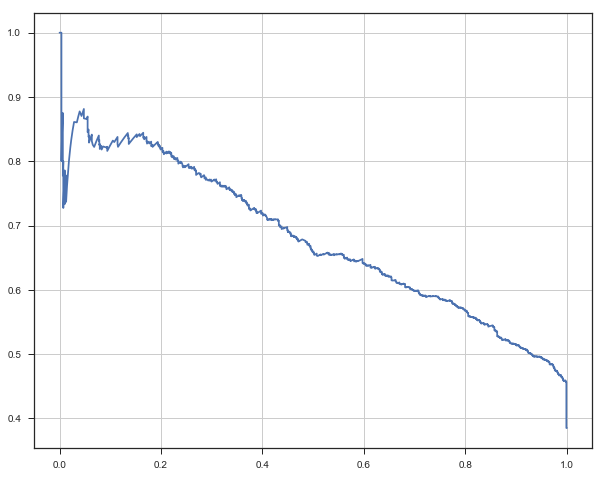

In [669]:
from sklearn.metrics import precision_recall_curve


fix, ax = plt.subplots(figsize=(10, 8))
precision, recall, thresholds = precision_recall_curve(
    y_test,
    estimator.predict_proba(X_test)[:,1],
    pos_label=True)

ax.grid(True)
ax.plot(recall, precision)

Видим, что зависимость почти линейная, и сильно увеличить Precision не снизив Recall не выйдет, а значит оставляем пороги как есть.

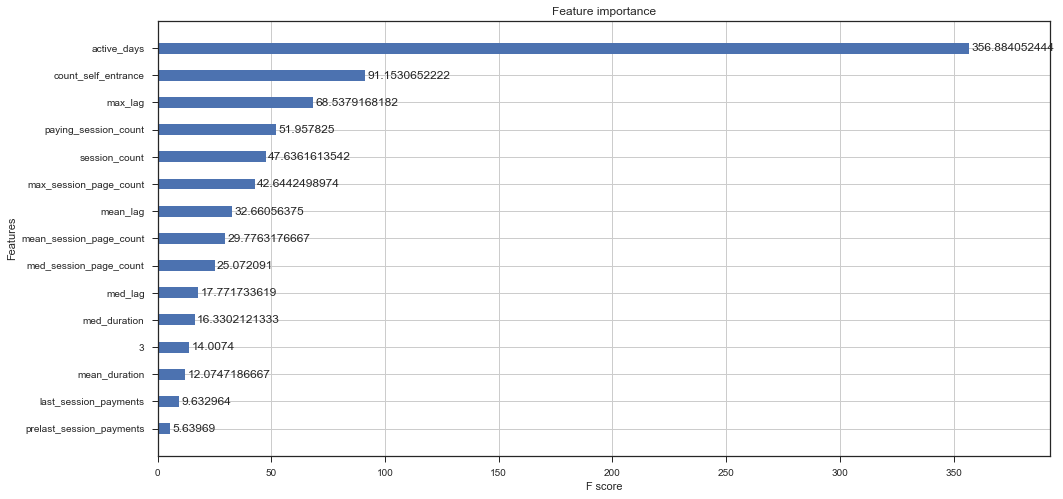

In [671]:
fig, ax = plt.subplots(figsize=(16, 8))
xgb.plot_importance(estimator.booster(), ax=ax, height=0.4, max_num_features=15, importance_type='gain')

In [682]:
fscores = pd.Series(estimator.booster().get_fscore()).sort_values(ascending=False)
important_features = fscores[:9].index.values.tolist()

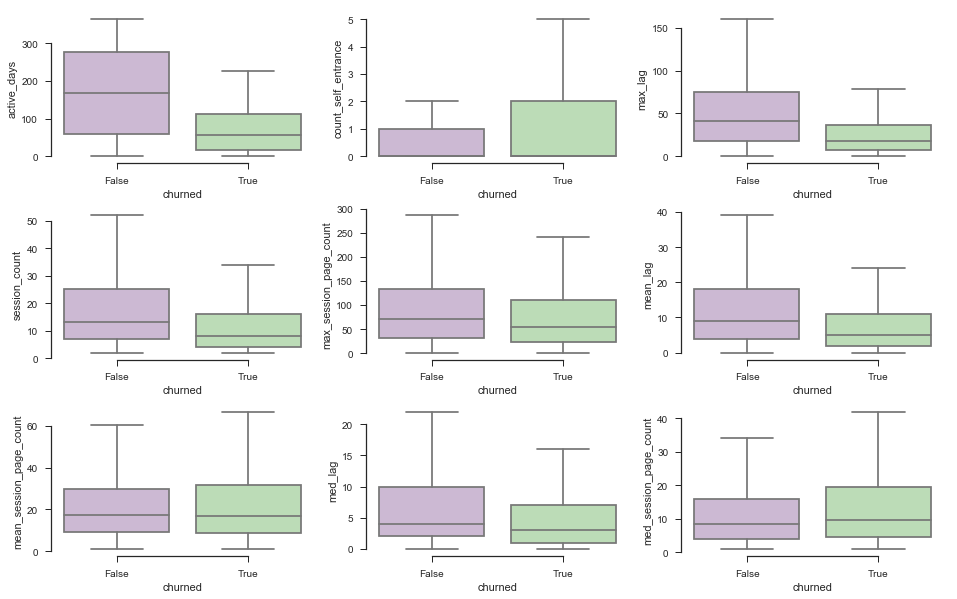

In [683]:
import seaborn as sns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,10))
for idx, feature in enumerate(important_features):
    sns.boxplot(y=feature, x='churned', data=sample_raw, palette="PRGn", ax=axes[idx / 3, idx % 3], showfliers=False)
sns.despine(trim=True)
fig.subplots_adjust(hspace=0.3)

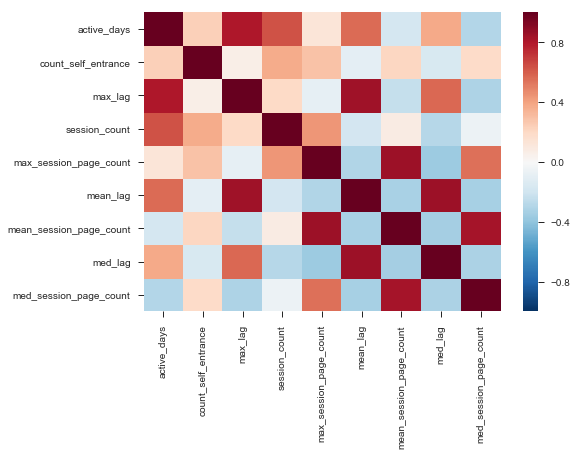

In [365]:
sns.heatmap(sample[important_features].corr(method='spearman'))

In [288]:
# xgb_tree = xgb.to_graphviz(estimator.booster(), num_trees=39)
# print type(xgb_tree)
# fig, ax = plt.subplots(figsize=(30, 50))
# xgb.plot_tree(estimator.booster(), num_trees=39, ax=ax)

In [102]:
middle_valued = pd.DataFrame()
middle_valued['monetary'] = paying_users_monetary[paying_users_monetary <= paying_users_monetary.quantile(q=.8)]
len(middle_valued)

44235

In [103]:
# middle_valued_data = data.loc[middle_valued.index.values.tolist()]
# middle_valued_data.to_csv('middle_valued_data.csv')

middle_valued_data = pd.read_csv('middle_valued_data.csv', index_col=[0,1],  parse_dates=['timestamp'])

In [104]:
middle_valued['frequency'] = middle_valued_data.groupby(level=0,sort=False).apply(lambda udf: udf.index.values[-1][1])

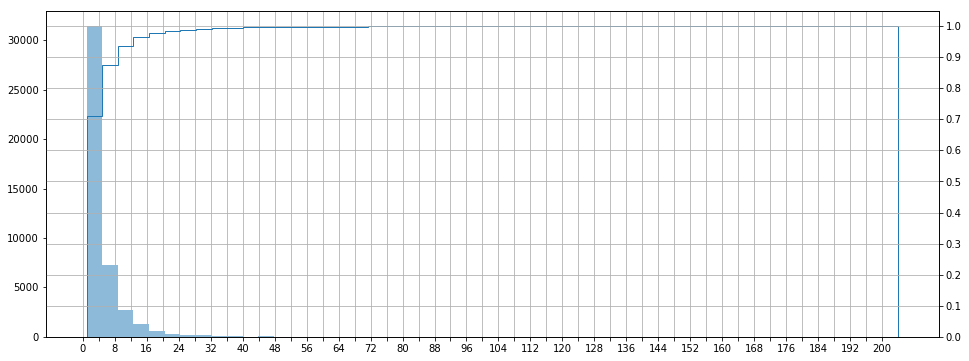

In [105]:
plot_frequency(middle_valued['frequency'])

In [106]:
print len(middle_valued[middle_valued.frequency == 1])
print len(middle_valued[middle_valued.frequency == 1]) / float(len(middle_valued))

15312
0.346151237708


In [108]:
middle_valued = middle_valued[middle_valued.frequency > 1].sample(len(most_valued), random_state=1)
# middle_valued_data = middle_valued_data.loc[middle_valued.index.values.tolist()]
# middle_valued_data.to_csv('middle_valued_upd_data.csv')

middle_valued_data = pd.read_csv('middle_valued_upd_data.csv', index_col=[0,1],  parse_dates=['timestamp'])

In [169]:
# middle_valued_data.dtypes

timestamp    datetime64[ns]
hit                  object
geo_id                int64
category             object
price               float64
dtype: object

In [303]:
# %%time
# middle_valued_gfe = GeoFeaturesExtractor(geo, middle_valued_data).run()
# most_valued_gfe = GeoFeaturesExtractor(geo, most_valued_data).run()



In [170]:
# middle_valued_nfe = NumericalFeaturesExtractor(middle_valued_data).run()

In [249]:
# geo_features2 = pd.concat([most_valued_gfe.features, middle_valued_gfe.features])
# mlb2 = MultiLabelBinarizer()
# geo_features2 = pd.DataFrame(data=mlb2.fit_transform(geo_features2),
#                             columns=mlb2.classes_,
#                             index=geo_features2.index)

In [295]:
# most_valued_num_features = sample_raw.iloc[:, numerical_cols_indexes]
# middle_valued_num_features = middle_valued_nfe.features
# num_features2 = pd.concat([most_valued_num_features, middle_valued_num_features])

In [296]:
# target = pd.concat([pd.Series(True, index=most_valued.index.values, name='is_most_valued'),
#                     pd.Series(False, index=middle_valued.index.values, name='is_most_valued')])

In [300]:
# sample2_raw = pd.concat([target, num_features2, geo_features2], axis=1)
# sample2_raw.to_csv('sample2_raw.csv')

In [542]:
scaler2 = StandardScaler()
sample2_raw = pd.read_csv('sample2_raw.csv', index_col=[0])
numerical_cols_indexes = range(1,17)

sample2 = sample2_raw.copy()
sample2.iloc[:,numerical_cols_indexes] = scaler2.fit_transform(sample2.iloc[:,numerical_cols_indexes])
sample2.head()

is_most_valued  active_days  \
00023fcc5c93cb4674bdad0d448272e6           True     2.054814   
00045ac92fb4ed78bc66c40f52775acd          False    -1.059989   
0005ed3cc99ddb0def30bf53466366ee          False    -1.003527   
000b71102168827ca5271edbdc20c908          False    -0.975296   
0012f25a1f01cffc352294619250cd13          False     0.360963   

                                  count_self_entrance  last_session_duration  \
00023fcc5c93cb4674bdad0d448272e6            -0.093490              -0.350406   
00045ac92fb4ed78bc66c40f52775acd            -0.324858              -0.386294   
0005ed3cc99ddb0def30bf53466366ee            -0.324858               1.061191   
000b71102168827ca5271edbdc20c908            -0.324858              -0.386294   
0012f25a1f01cffc352294619250cd13            -0.324858              -0.386294   

                                  last_session_payments   max_lag  \
00023fcc5c93cb4674bdad0d448272e6              -0.437780  0.595289   
00045ac92fb4ed78bc66c40f52775acd              -0.437780 -0.918607   
0005ed3cc99ddb0def30bf53466366ee               1.091283 -0.878768   
000b71102168827ca5271edbdc20c908              -0.437780 -0.739330   
0012f25a1f01cffc352294619250cd13              -0.055514  2.089266   

                                  max_session_page_count  mean_duration  \
00023fcc5c93cb4674bdad0d448272e6                0.348660      -0.326299   
00045ac92fb4ed78bc66c40f52775acd               -0.551985      -0.694932   
0005ed3cc99ddb0def30bf53466366ee               -0.373950      -0.050066   
000b71102168827ca5271edbdc20c908               -0.677656      -0.764917   
0012f25a1f01cffc352294619250cd13               -0.604348      -0.734924   

                                  mean_lag  mean_session_page_count   ...    \
00023fcc5c93cb4674bdad0d448272e6 -0.270720                -0.260695   ...     
00045ac92fb4ed78bc66c40f52775acd -0.652359                -0.474177   ...     
0005ed3cc99ddb0def30bf53466366ee -0.582970                -0.295597   ...     
000b71102168827ca5271edbdc20c908 -0.340108                -0.726289   ...     
0012f25a1f01cffc352294619250cd13  4.586509                -0.579224   ...     

                                  121220  121221  121455  121477  121479  \
00023fcc5c93cb4674bdad0d448272e6       0       0       0       0       0   
00045ac92fb4ed78bc66c40f52775acd       0       0       0       0       0   
0005ed3cc99ddb0def30bf53466366ee       0       0       0       0       0   
000b71102168827ca5271edbdc20c908       0       0       0       0       0   
0012f25a1f01cffc352294619250cd13       0       0       0       0       0   

                                  121905  121997  122005  122009  145633  
00023fcc5c93cb4674bdad0d448272e6       0       0       0       0       0  
00045ac92fb4ed78bc66c40f52775acd       0       0       0       0       0  
0005ed3cc99ddb0def30bf53466366ee       0       0       0       0       0  
000b71102168827ca5271edbdc20c908       0       0       0       0       0  
0012f25a1f01cffc352294619250cd13       0       0       0       0       0  

[5 rows x 1488 columns]

In [543]:
target2 = sample2.columns.values[0]
features2 = sample2.columns.values[1:]

In [544]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    sample2[features2],
    sample2[target2],
    test_size=0.33,
    random_state=1,
    stratify=sample2[target2])

In [545]:
print len(y_train2), len(y_train2[y_train2 == True]), len(y_train2[y_train2 == True])/float(len(y_train2))
print len(y_test2), len(y_test2[y_test2 == True]), len(y_test2[y_test2 == True])/float(len(y_test2))

13019 6509 0.499961594593
6413 3207 0.50007796663


In [704]:
# default_xgb_params2 = {
#     'objective': "binary:logistic",
#     'learning_rate': 0.1,
#     'max_depth': 5,
#     'n_estimators': 1000,
#     'min_child_weight': 1,
#     'gamma':0.,
#     'subsample': .8,
#     'colsample_bytree': .8,
#     'seed': 1,
#     'silent': True,
#     'scale_pos_weight': float(len(sample2[sample2[target2] == False])) / len(sample2[sample2[target2] == True])
# }

# estimator2 = xgb.XGBClassifier(**default_xgb_params2)
# modelfit(estimator2, X_train2, y_train2)

In [702]:
# from sklearn.metrics import roc_auc_score

# print "AUC (Test) : %.10g"  %  roc_auc_score(y_test2, estimator2.predict_proba(X_test2)[:,1])

In [703]:
# from sklearn.model_selection import GridSearchCV

# searchgrid_params2 = {
#     'scoring': 'roc_auc',
#     'iid': False,
#     'cv': 3,
#     'estimator': estimator2
# }

# param_grid = {
#     'max_depth':range(3,10,2),
#     'min_child_weight':range(1,10,2)
# }

# gsearch = GridSearchCV(param_grid=param_grid, **searchgrid_params2)
# gsearch.fit(X_train2, y_train2)
# gsearch.best_params_, gsearch.best_score_

In [701]:
# estimator2.set_params(**gsearch.best_params_)
# modelfit(estimator2, X_train2, y_train2)

In [700]:
# print "AUC (Test) : %.10g"  %  roc_auc_score(y_test2, estimator2.predict_proba(X_test2)[:,1])

In [699]:
# param_grid = {
#     'gamma':[i/10.0 for i in range(0,3)]
# }

# gsearch = GridSearchCV(param_grid=param_grid, **searchgrid_params2)
# gsearch.fit(X_train2, y_train2)
# gsearch.best_params_, gsearch.best_score_

In [698]:
# param_grid = {
#     'subsample':[i/10.0 for i in range(5,10,2)],
#     'colsample_bytree':[i/10.0 for i in range(5,10,2)]
# }

# gsearch = GridSearchCV(param_grid=param_grid, **searchgrid_params2)
# gsearch.fit(X_train2, y_train2)
# gsearch.best_params_, gsearch.best_score_

In [697]:
# param_grid = {
#     'subsample':[.6,.7,.8],
#     'colsample_bytree':[.8,.9,1]
# }

# gsearch = GridSearchCV(param_grid=param_grid, **searchgrid_params2)
# gsearch.fit(X_train2, y_train2)
# gsearch.best_params_, gsearch.best_score_

In [696]:
# estimator2.set_params(**gsearch.best_params_)
# modelfit(estimator2, X_train2, y_train2)

In [695]:
# param_grid={
#     'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
# }

# gsearch = GridSearchCV(param_grid=param_grid, **searchgrid_params2)
# gsearch.fit(X_train2, y_train2)
# gsearch.best_params_, gsearch.best_score_

In [694]:
# estimator2.set_params(**gsearch.best_params_)
# modelfit(estimator2, X_train2, y_train2)

In [693]:
# estimator2.set_params(learning_rate=.01)
# modelfit(estimator2, X_train2, y_train2)

In [692]:
# estimator2.get_params()

In [664]:
optimal_xgb_params2 = {
'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.01,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 7,
 'missing': None,
 'n_estimators': 69,
 'nthread': -1,
 'objective': 'binary:logistic',
 'reg_alpha': 1e-05,
 'reg_lambda': 1,
 'scale_pos_weight': 1.0,
 'seed': 1,
 'silent': True,
 'subsample': 0.8
}

estimator2 = xgb.XGBClassifier(**optimal_xgb_params2)
modelfit(estimator2, X_train2, y_train2)

AUC (Train) : 0.8878033582


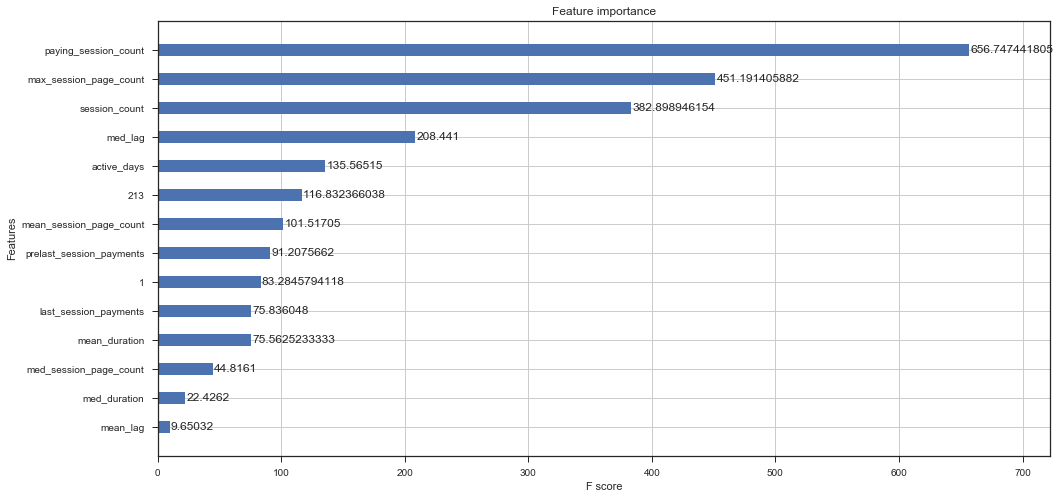

In [707]:
fig, ax = plt.subplots(figsize=(16, 8))
xgb.plot_importance(estimator2.booster(), ax=ax, height=0.4, max_num_features=20, importance_type='gain')

In [709]:
fscores2 = pd.Series(estimator2.booster().get_fscore()).sort_values(ascending=False)
important_features2 = fscores2[:12].index.values.tolist()

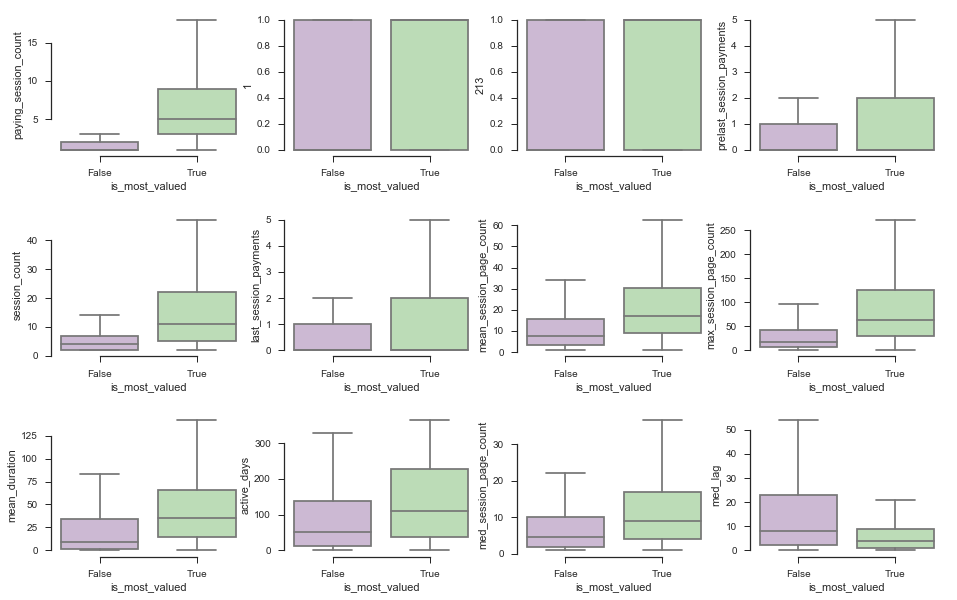

In [710]:
import seaborn as sns
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,10))
for idx, feature in enumerate(important_features2):
    sns.boxplot(y=feature, x='is_most_valued', data=sample2_raw, palette="PRGn", ax=axes[idx / 4, idx % 4], showfliers=False)
sns.despine(trim=True)
fig.subplots_adjust(hspace=0.4)

In [712]:
print geo.tree.get_node(1).tag
print geo.tree.get_node(213).tag

Москва и Московская область
Москва


In [719]:
len(sample2[(sample2['1'] == True) & (sample2.is_most_valued)])/float(len(sample2[sample2.is_most_valued]))

0.6218608480856319

In [717]:
len(sample2[(sample2['1'] == True) & (sample2.is_most_valued)]) \
/ float(len(sample2[(sample2['1'] == True) & (sample2.is_most_valued)]))

0.6080767957629923

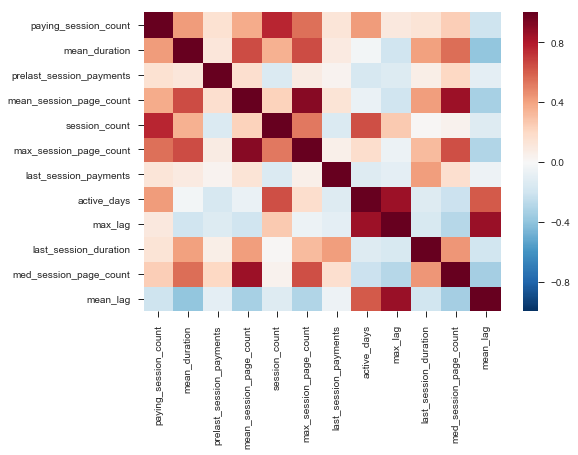

In [705]:
sns.heatmap(sample2[important_features2].corr(method='spearman'))

In [418]:
unvalued = users_monetary[users_monetary == 0.]
unvalued = unvalued.to_frame(name='monetary')
len(unvalued)

243945

In [420]:
unvalued = unvalued.sample(frac=.2, random_state=1)

In [423]:
# unvalued_data = data.loc[unvalued.index.values.tolist()]
# unvalued_data.to_csv('unvalued_sample20_data.csv')

unvalued_data = pd.read_csv('unvalued_sample20_data.csv', index_col=[0,1],  parse_dates=['timestamp'])

In [425]:
unvalued['frequency'] = unvalued_data.groupby(level=0,sort=False).apply(lambda udf: udf.index.values[-1][1])

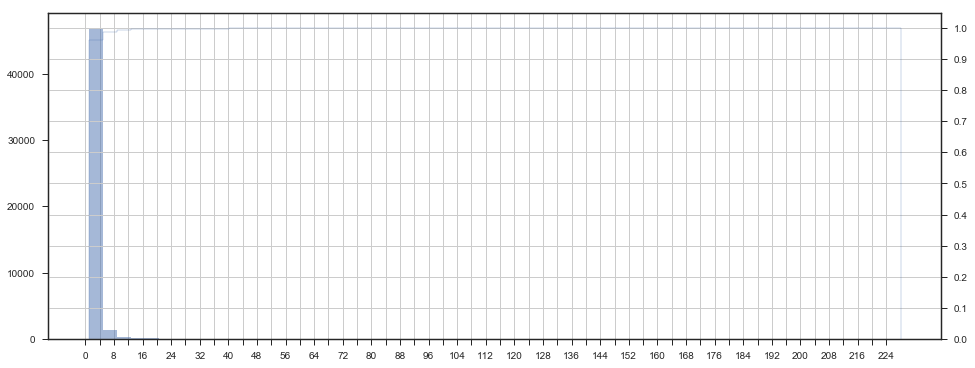

In [427]:
plot_frequency(unvalued['frequency'])

In [428]:
print len(unvalued[unvalued.frequency == 1])
print len(unvalued[unvalued.frequency == 1]) / float(len(unvalued))

40260
0.825186005042


Видим что 83% неприбыльных пользователей совершили всего одну сессию. Это дает нам понять, что необходимо оценивать качество каналов откуда они приходят, а также происследовать вопрос первой сессии более детально. Если каналы не покажут сильной разницы (я предполагаю, что основной трафик из поиска) то стоит посмотреть на категории товаров, возможно причины именно там. Далее я бы создал поведеньческие фичи, вида "Сразу покинул сайт с товаров", "Просмотрел другие магазины", "Читал отзывы", "Ушел на сайт магазина и не вернулся", и др.

In [450]:
print len(unvalued[unvalued.frequency > 100]) / float(len(unvalued))
print len(unvalued[unvalued.frequency > 100])

0.000143474963619
7


In [455]:
#кажется какие-то боты
#unvalued_data.loc[unvalued[unvalued.frequency > 100].index.values.tolist(), :]

In [456]:
unvalued = unvalued[(unvalued.frequency > 1) & (unvalued.frequency < 100)]
unvalued_data = unvalued_data.loc[unvalued.index.values.tolist()]

In [459]:
# numerical_cols_indexes = range(1,17)
# middle_valued_num_features = sample2_raw[sample2_raw.is_most_valued == False].iloc[:,numerical_cols_indexes]
# unvalued_num_features= NumericalFeaturesExtractor(unvalued_data).run().features

In [461]:
# num_features3 = pd.concat([middle_valued_num_features, unvalued_num_features])
# target = pd.concat([pd.Series(True, index=unvalued.index.values, name='is_unvalued'),
#                     pd.Series(False, index=middle_valued.index.values, name='is_unvalued')])


In [462]:
# sample3_raw = pd.concat([target, num_features3], axis=1)
# sample3_raw.to_csv('sample3_raw.csv')

In [475]:
scaler3 = StandardScaler()
sample3_raw = pd.read_csv('sample3_raw.csv', index_col=[0])
sample3_raw=sample3_raw.drop(['paying_session_count',
                              'prelast_session_payments','last_session_payments'], 1)
numerical_cols_indexes = range(1,14)

sample3 = sample3_raw.copy()
sample3.iloc[:,numerical_cols_indexes] = scaler3.fit_transform(sample3.iloc[:,numerical_cols_indexes])
sample3.head()

is_unvalued  active_days  \
0002e295e0f06306e7d98c1e163f7b84        True    -0.814122   
00045ac92fb4ed78bc66c40f52775acd       False    -0.859318   
0005ed3cc99ddb0def30bf53466366ee       False    -0.791523   
000b71102168827ca5271edbdc20c908       False    -0.757626   
0012f25a1f01cffc352294619250cd13       False     0.846852   

                                  count_self_entrance  last_session_duration  \
0002e295e0f06306e7d98c1e163f7b84            -0.292187              -0.298345   
00045ac92fb4ed78bc66c40f52775acd            -0.292187              -0.298345   
0005ed3cc99ddb0def30bf53466366ee            -0.292187               1.535822   
000b71102168827ca5271edbdc20c908            -0.292187              -0.298345   
0012f25a1f01cffc352294619250cd13            -0.292187              -0.298345   

                                   max_lag  max_session_page_count  \
0002e295e0f06306e7d98c1e163f7b84 -0.745910               -0.447512   
00045ac92fb4ed78bc66c40f52775acd -0.819593               -0.218638   
0005ed3cc99ddb0def30bf53466366ee -0.782752                0.135076   
000b71102168827ca5271edbdc20c908 -0.653807               -0.468319   
0012f25a1f01cffc352294619250cd13  1.961919               -0.322672   

                                  mean_duration  mean_lag  \
0002e295e0f06306e7d98c1e163f7b84      -0.182925 -0.580265   
00045ac92fb4ed78bc66c40f52775acd      -0.428133 -0.686485   
0005ed3cc99ddb0def30bf53466366ee       0.325007 -0.633375   
000b71102168827ca5271edbdc20c908      -0.509869 -0.447489   
0012f25a1f01cffc352294619250cd13      -0.474840  3.323344   

                                  mean_session_page_count  med_duration  \
0002e295e0f06306e7d98c1e163f7b84                -0.458648      0.064321   
00045ac92fb4ed78bc66c40f52775acd                -0.141262     -0.218311   
0005ed3cc99ddb0def30bf53466366ee                 0.103991     -0.016431   
000b71102168827ca5271edbdc20c908                -0.487502     -0.312522   
0012f25a1f01cffc352294619250cd13                -0.285528     -0.272146   

                                   med_lag  med_session_page_count  \
0002e295e0f06306e7d98c1e163f7b84 -0.505565               -0.354465   
00045ac92fb4ed78bc66c40f52775acd -0.611998               -0.006591   
0005ed3cc99ddb0def30bf53466366ee -0.558781               -0.101466   
000b71102168827ca5271edbdc20c908 -0.372524               -0.386090   
0012f25a1f01cffc352294619250cd13  3.405843               -0.164716   

                                  prelast_session_duration  session_count  
0002e295e0f06306e7d98c1e163f7b84                  0.101071      -0.492040  
00045ac92fb4ed78bc66c40f52775acd                 -0.211219      -0.492040  
0005ed3cc99ddb0def30bf53466366ee                 -0.315315      -0.193057  
000b71102168827ca5271edbdc20c908                 -0.315315      -0.492040  
0012f25a1f01cffc352294619250cd13                 -0.270702      -0.492040

In [476]:
target3 = sample3.columns.values[0]
features3 = sample3.columns.values[1:]

In [477]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(
    sample3[features3],
    sample3[target3],
    test_size=0.33,
    random_state=1,
    stratify=sample3[target3])

In [494]:

default_xgb_params3 = {
    'objective': "binary:logistic",
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 1000,
    'min_child_weight': 1,
    'gamma':0,
    'subsample': .8,
    'colsample_bytree': .8,
    'seed': 1,
    'silent': True,
    'scale_pos_weight': float(len(sample3[sample3[target3] == False])) / len(sample3[sample3[target3] == True])
}

estimator3 = xgb.XGBClassifier(**default_xgb_params3)
modelfit(estimator3, X_train3, y_train3)

AUC (Train) : 0.8182762975


In [519]:
# from sklearn.metrics import roc_auc_score

# print "AUC (Test) : %.10g"  %  roc_auc_score(y_test3, estimator3.predict_proba(X_test3)[:,1])

In [518]:
# searchgrid_params = {
#     'scoring': 'roc_auc',
#     'n_jobs': 4,
#     'iid': False,
#     'cv': 3,
#     'estimator': estimator3
# }

# param_grid = {
#     'max_depth':range(3,10),
#     'min_child_weight':range(1,12)
# }

# gsearch = GridSearchCV(param_grid=param_grid, **searchgrid_params)
# gsearch.fit(X_train3, y_train3)
# gsearch.best_params_, gsearch.best_score_

In [517]:
# estimator3.set_params(**gsearch.best_params_)
# modelfit(estimator3, X_train3, y_train3)

In [516]:
# param_grid = {
#     'gamma':[i/10.0 for i in range(0,5)]
# }

# gsearch = GridSearchCV(param_grid=param_grid, **searchgrid_params)
# gsearch.fit(X_train3, y_train3)
# gsearch.best_params_, gsearch.best_score_

In [515]:
# estimator3.set_params(**gsearch.best_params_)
# modelfit(estimator3, X_train3, y_train3)

In [514]:
# param_grid = {
#     'subsample':[i/10.0 for i in range(5,10)],
#     'colsample_bytree':[i/10.0 for i in range(5,10)]
# }

# gsearch = GridSearchCV(param_grid=param_grid, **searchgrid_params)
# gsearch.fit(X_train3, y_train3)
# gsearch.best_params_, gsearch.best_score_

In [513]:
# estimator3.set_params(**gsearch.best_params_)
# modelfit(estimator3, X_train3, y_train3)

In [512]:
# param_grid={
#     'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
# }

# gsearch = GridSearchCV(param_grid=param_grid, **searchgrid_params)
# gsearch.fit(X_train3, y_train3)
# gsearch.best_params_, gsearch.best_score_

In [511]:
# estimator3.set_params(**gsearch.best_params_)
# modelfit(estimator3, X_train3, y_train3)

In [510]:
# estimator3.set_params(learning_rate=0.01)
# modelfit(estimator3, X_train3, y_train3)

In [508]:
optimal_xgb_params3={
    'base_score': 0.5,
    'colsample_bylevel': 1,
    'colsample_bytree': 0.8,
    'gamma': 0.3,
    'learning_rate': 0.01,
    'max_delta_step': 0,
    'max_depth': 5,
    'min_child_weight': 9,
    'missing': None,
    'n_estimators': 39,
    'objective': 'binary:logistic',
    'reg_alpha': 1,
    'reg_lambda': 1,
    'scale_pos_weight': 1.1401079558789016,
    'seed': 1,
    'silent': 1,
    'subsample': 0.7
}

estimator3 = xgb.XGBClassifier(**optimal_xgb_params3)
modelfit(estimator3, X_train3, y_train3)

AUC (Train) : 0.7964383547


In [509]:
from sklearn.metrics import roc_auc_score

print "AUC (Test) : %.10g"  %  roc_auc_score(y_test3, estimator3.predict_proba(X_test3)[:,1])

AUC (Test) : 0.7887602843


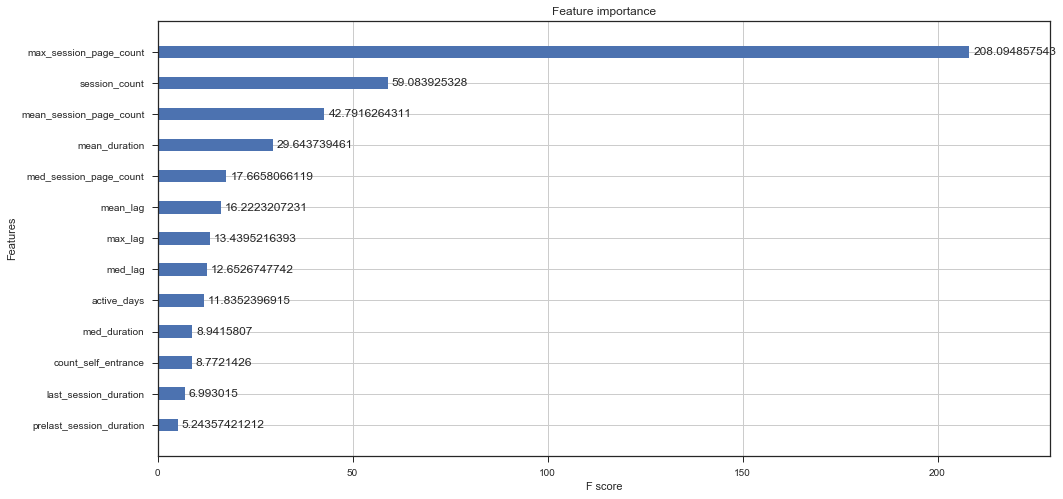

In [690]:
fig, ax = plt.subplots(figsize=(16, 8))
xgb.plot_importance(estimator3.booster(), ax=ax, height=0.4, max_num_features=20, importance_type='gain')

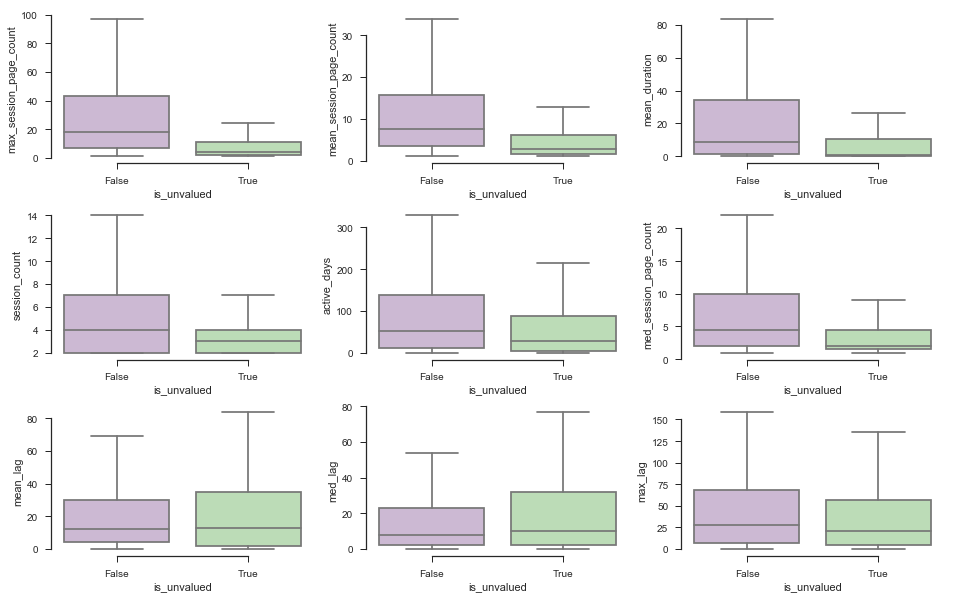

In [691]:
fscores3 = pd.Series(estimator3.booster().get_fscore()).sort_values(ascending=False)
important_features3 = fscores3[:9].index.values.tolist()

import seaborn as sns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,10))
for idx, feature in enumerate(important_features3):
    sns.boxplot(y=feature, x='is_unvalued', data=sample3_raw, palette="PRGn", ax=axes[idx / 3, idx % 3], showfliers=False)
sns.despine(trim=True)
fig.subplots_adjust(hspace=0.3)

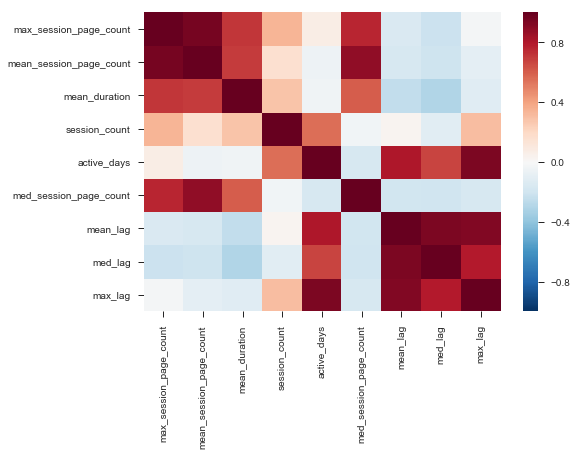

In [532]:
sns.heatmap(sample3[important_features3].corr(method='spearman'))